In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path
from os import path

from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from IPython.display import SVG
import re

In [79]:
pairs = pd.read_csv('data/Main_RPAIRS_KEGG.tsv', sep='\t')
pairs['source'] = pairs['Reactant_pair'].apply(lambda x: x.split('_')[0])
pairs['target'] = pairs['Reactant_pair'].apply(lambda x: x.split('_')[1])
pairs.shape

(10747, 6)

In [80]:
df = pd.read_csv('data/compounds_list_KEGG.csv')
df.head()

,id,mol_weight,formula
0,C00002,507.1810,C10H16N5O13P3
1,C00003,664.4330,C21H28N7O14P2
2,C00005,745.4209,C21H30N7O17P3
3,C00007,31.9988,O2
4,C00011,44.0095,CO2


In [81]:
df.shape

(5620, 3)

How many nans

In [82]:
df.isna().sum()

id              0
mol_weight    680
formula         2
dtype: int64

In [83]:
# These are probably mistakes
display(df[df['formula'].isna()])

,id,mol_weight,formula
665,C15778,NaN,NaN
2845,C20798,NaN,NaN


### Fix manually these mistakes

**Correct *C15778***

In [84]:
pairs[pairs['source'] == 'C15778']

,Reactant_pair,CAR,KEGG_reactions,RPAIR_main,source,target
787,C15778_C15781,1.0,R07492,False,C15778,C15781


In [85]:
pairs[pairs['target'] == 'C15778']

,Reactant_pair,CAR,KEGG_reactions,RPAIR_main,source,target


According to **KEGG** for the Reaction *R07492*, *C15778* should be *C15780*

In [86]:
pairs.loc[pairs.index[787], 'Reactant_pair'] = 'C15780_C15781'

df.loc[df.index[665], 'id'] = 'C15780'
df.loc[df.index[665], 'mol_weight'] = 396.6484
df.loc[df.index[665], 'formula'] = 'C28H44O'

**Correct *C20798***

In [87]:
pairs[pairs['source'] == 'C20798']

,Reactant_pair,CAR,KEGG_reactions,RPAIR_main,source,target
5112,C20798_C21180,0.480,R11213,False,C20798,C21180
5767,C20798_C20831,0.349,R10760,True,C20798,C20831


In [88]:
pairs[pairs['target'] == 'C20798']

,Reactant_pair,CAR,KEGG_reactions,RPAIR_main,source,target
890,C19675_C20798,1.000,R10719,False,C19675,C20798
2787,C11499_C20798,0.855,"R11677,R11678",False,C11499,C20798


According to **KEGG** for the Reaction *R10719*, *C20798* should be *C21181*

In [89]:
pairs.loc[pairs.index[5112], 'Reactant_pair'] = 'C21181_C21180'
pairs.loc[pairs.index[5767], 'Reactant_pair'] = 'C21181_C20831'
pairs.loc[pairs.index[890], 'Reactant_pair'] = 'C19675_C21181'
pairs.loc[pairs.index[2787], 'Reactant_pair'] = 'C11499_C21181'

df.loc[df.index[2845], 'id'] = 'C21181'
df.loc[df.index[2845], 'mol_weight'] = 154.1417
df.loc[df.index[2845], 'formula'] = 'C3H6O5S'

Recalculate *source* and *target* in pairs

In [90]:
pairs['source'] = pairs['Reactant_pair'].apply(lambda x: x.split('_')[0])
pairs['target'] = pairs['Reactant_pair'].apply(lambda x: x.split('_')[1])

pairs.to_csv('data/Main_RPAIRS_KEGG_fixed.csv', index=None)

## Exctract Features From Chemical Formula

In [91]:
def extract_elements(df, column_name):
    # define the regular expression pattern to match the chemical formula
    pattern = r'[A-Z][a-z]?'
    # initialize a set to store the element symbols
    elements = set()
    # loop over the values in the specified column of the DataFrame
    for value in df[column_name].values:
        # find all matches of the pattern in the value string
        matches = re.findall(pattern, value)
        # add the matches to the set of elements
        elements.update(matches)
    return elements

def extract_stoichiometry(formula):
    # define the regular expression pattern to match the chemical formula
    pattern = r'([A-Z][a-z]?)(\d*)'
    # initialize the dictionary to store the element symbol and its stoichiometry
    stoichiometry = {}
    # loop over the matches of the pattern in the formula string
    for match in re.findall(pattern, formula):
        symbol, count = match
        # if the count is empty, set it to 1
        count = int(count) if count else 1
        # add the symbol and count to the stoichiometry dictionary
        stoichiometry[symbol] = count
    return stoichiometry

# example usage
elements = extract_elements(df, 'formula')
print(elements)

# Create a col for every element
for elm in elements: df[elm]=0

{'Br', 'P', 'N', 'R', 'S', 'H', 'C', 'Cl', 'Co', 'Se', 'Mo', 'As', 'F', 'Zn', 'Mg', 'X', 'I', 'O'}


In [92]:
for row in range(len(df)):
    
    formula = df['formula'].iloc[row]
    stoichiometry = extract_stoichiometry(formula)
    
    for key, value in stoichiometry.items():
        #df[key].iloc[row] = value
        df.loc[df.index[row], key] = value

In [93]:
df.head(3)

,id,mol_weight,formula,Br,P,N,R,S,H,C,...,Co,Se,Mo,As,F,Zn,Mg,X,I,O
0,C00002,507.1810,C10H16N5O13P3,0,3,5,0,0,16,10,...,0,0,0,0,0,0,0,0,0,13
1,C00003,664.4330,C21H28N7O14P2,0,2,7,0,0,28,21,...,0,0,0,0,0,0,0,0,0,14
2,C00005,745.4209,C21H30N7O17P3,0,3,7,0,0,30,21,...,0,0,0,0,0,0,0,0,0,17


In [94]:
# Many many compounds with R
print(len(df[df['R']!=0]))

# Col that contains the info if the compound is a polymer or not
df['polymer'] = 0

for row in range(len(df)):
    if 'n' in df['formula'].iloc[row]: 
        df.loc[df.index[row], 'polymer'] = 1
        
# Print how many polymers do we have
print(len(df[df['polymer'] == 1]))

597
129


In [95]:
df[df['mol_weight'].isna()]

,id,mol_weight,formula,Br,P,N,R,S,H,C,...,Se,Mo,As,F,Zn,Mg,X,I,O,polymer
23,C00071,NaN,CHOR,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,1,0
54,C00161,NaN,C2HO3R,0,0,0,1,0,1,2,...,0,0,0,0,0,0,0,0,3,0
58,C00173,NaN,C3H4OSR2,0,0,0,2,1,4,3,...,0,0,0,0,0,0,0,0,1,0
64,C00195,NaN,C19H36NO3R,0,0,1,1,0,36,19,...,0,0,0,0,0,0,0,0,3,0
83,C00264,NaN,C24H37N7O18P3SR,0,3,7,1,1,37,24,...,0,0,0,0,0,0,0,0,18,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5583,C15544,NaN,C14H24NO11R,0,0,1,1,0,24,14,...,0,0,0,0,0,0,0,0,11,0
5602,C18009,NaN,C9H15N2O5SR,0,0,2,1,1,15,9,...,0,0,0,0,0,0,0,0,5,0
5609,C02000,NaN,HSO4R,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,4,0
5610,C02885,NaN,HS2O3R,0,0,0,1,2,1,0,...,0,0,0,0,0,0,0,0,3,0


In [96]:
df['mol_weight'].fillna(999, inplace=True)

# Import to Networkx 

In [97]:
import networkx as nx

G = nx.Graph()

# add edges from the DataFrame
G.add_edges_from(pairs[['source', 'target']].values)

# Add df cols as node features
node_data = df.set_index('id').to_dict('index')

# Add the node features to the graph
for node, data in G.nodes(data=True):
    node_features = node_data.get(node)
    if node_features:
        data.update(node_features)

print(G.number_of_nodes(), G.number_of_edges())

5620 10747


In [98]:
if path.exists('data/nodes_centralities.csv'):
    dc = pd.read_csv('data/nodes_centralities.csv', index_col=0)
else:
    # PageRank
    pr = nx.pagerank(G)
    pr = pd.DataFrame(list(pr.items()), columns=['Node', 'PageRank'])

    # degree centrality
    dc = nx.degree_centrality(G)
    dc = pd.DataFrame(list(dc.items()), columns=['Node', 'Degree Centrality'])
    
    # Betweenness centrality
    bc = nx.betweenness_centrality(G)
    bv = pd.DataFrame(list(bc.items()), columns=['Node', 'Betweenness Centrality'])
    
    # centralities
    dc['PageRank'] = pr['PageRank'].copy()
    dc['Betweenness Centrality'] = bc['Betweenness Centrality'].copy()
    dc.sort_values(by='PageRank', ascending=False, inplace=True)
    dc = pd.merge(dc, df[['id','formula','mol_weight']].rename({'id':'Node'}, axis=1), on='Node')
    dc.to_csv('data/nodes_centralities.csv')
    
dc.head(20)

,Node,Degree Centrality,PageRank,Betweenness Centrality,formula,mol_weight
0,C00001,0.163018,0.034408,0.473722,H2O,18.0153
1,C00007,0.127247,0.030908,0.284550,O2,31.9988
2,C00019,0.064068,0.016209,0.134686,C15H22N6O5S,398.4374
3,C00029,0.033814,0.007744,0.061145,C15H24N2O17P2,566.3018
4,C00002,0.040043,0.007642,0.070029,C10H16N5O13P3,507.1810
5,C00011,0.038263,0.007359,0.075367,CO2,44.0095
6,C00014,0.037729,0.007142,0.030839,NH3,17.0305
7,C00009,0.034348,0.006343,0.046956,H3PO4,97.9952
8,C00024,0.028297,0.006223,0.035959,C23H38N7O17P3S,809.5708
9,C00010,0.021178,0.004577,0.021383,C21H36N7O16P3S,767.5341


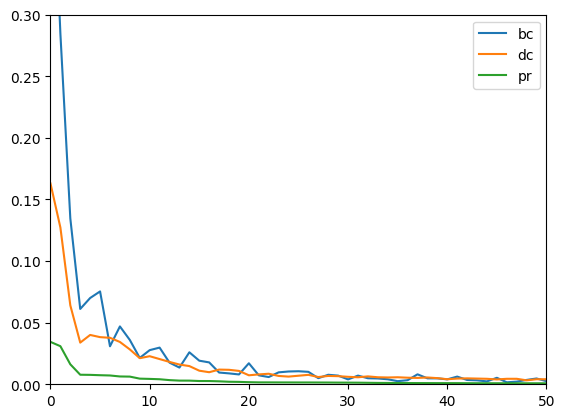

In [99]:
plt.plot(dc.index, dc['Betweenness Centrality'])
plt.plot(dc.index, dc['Degree Centrality'])
plt.plot(dc.index, dc['PageRank'])
plt.legend(['bc','dc','pr'])
plt.xlim(0, 50)
plt.ylim(0, 0.3)
plt.show()

#### Add edge attributes

In [100]:
def get_weights(a,b):
    if b in dc['Node'][:20].values or a in dc['Node'][:20].values:
        return 999
    else:
        return 0
    
# for edge in G.edges():
#     G.edges[(edge[0], edge[1])]['weight'] = get_weights(G.nodes[edge[0]]['mol_weight'], 
#                                                         G.nodes[edge[1]]['mol_weight'])
    
for edge in G.edges():
    G.edges[(edge[0], edge[1])]['weight'] = get_weights(edge[0], edge[1])

ex. Coa is C00010

In [101]:
source = 'C00082'
target = 'C01533'
list(nx.shortest_path(G, source, target, weight='weight'))

['C00082',
 'C00811',
 'C01197',
 'C01494',
 'C05619',
 'C00482',
 'C05610',
 'C02325',
 'C01533']

In [102]:
df[df['id'] == 'C00082']

,id,mol_weight,formula,Br,P,N,R,S,H,C,...,Se,Mo,As,F,Zn,Mg,X,I,O,polymer
29,C00082,181.1885,C9H11NO3,0,0,1,0,0,11,9,...,0,0,0,0,0,0,0,0,3,0


In [103]:
df[df['id'] == 'C00013']

,id,mol_weight,formula,Br,P,N,R,S,H,C,...,Se,Mo,As,F,Zn,Mg,X,I,O,polymer
2292,C00013,177.9751,H4P2O7,0,2,0,0,0,4,0,...,0,0,0,0,0,0,0,0,7,0


In [104]:
df[df['id']=='C00007']

,id,mol_weight,formula,Br,P,N,R,S,H,C,...,Se,Mo,As,F,Zn,Mg,X,I,O,polymer
3,C00007,31.9988,O2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0


### Get node embeddings using GNN (idea)

In [105]:
from torch_geometric.utils.convert import from_networkx
import torch_geometric.transforms as T
from torch_geometric.nn import SAGEConv
import torch
import torch.nn as nn
import torch.nn.functional as F

node_features = [col for col in df.drop(['id', 'formula'], axis=1).columns]

data = from_networkx(G, group_node_attrs=node_features)
data.x.shape

torch.Size([5620, 20])

In [106]:
mapping = {node: i for i, node in enumerate(G.nodes())}
G = nx.relabel_nodes(G, mapping)

# Add a new column to data.x with the node names from the mapping
node_names = [None] * len(data.x)
for node, index in mapping.items():
    node_names[index] = node
    
graph_data = np.column_stack((data.x, node_names))
graph_data = pd.DataFrame(graph_data)
graph_data

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,507.181,0.0,3.0,5.0,0.0,0.0,16.0,10.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,C00002
1,505.1651,0.0,3.0,5.0,0.0,0.0,14.0,10.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,C07024
2,664.433,0.0,2.0,7.0,0.0,0.0,28.0,21.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,C00003
3,665.441,0.0,2.0,7.0,0.0,0.0,29.0,21.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,C00004
4,745.4209,0.0,3.0,7.0,0.0,0.0,30.0,21.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,C00005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5615,20.0063,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,C16487
5616,28.0101,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,C00237
5617,999.0,0.0,3.0,7.0,1.0,1.0,39.0,24.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,C05232
5618,34.0809,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C00283


In [142]:
class SAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers):
        super(SAGE, self).__init__()
        self.num_layers = num_layers
        self.convs = nn.ModuleList()
        
        for i in range(num_layers):
            in_channels = in_channels if i == 0 else hidden_channels
            self.convs.append(SAGEConv(in_channels, hidden_channels))

    def forward(self, x, adjs):
        for i, (edge_index, _, size) in enumerate(adjs):
            x_target = x[:size[1]]  # Target nodes are always placed first.
            x = self.convs[i]((x, x_target), edge_index)
            if i != self.num_layers - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
        return x

    def full_forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i != self.num_layers - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SAGE(data.num_node_features, hidden_channels=64, \
             num_layers=2)

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

x, edge_index = data.x.to(device), data.edge_index.to(device)

# Forward propagate the graph through the model
model.eval()
with torch.no_grad():
    out = model.full_forward(data.x, data.edge_index)

# Extract the node embeddings
node_embeddings = out.numpy()  # or out.detach().numpy() if using PyTorch version <1.6

# Print the shape of the node embeddings matrix
print('Node embeddings shape:', node_embeddings.shape)

Node embeddings shape: (5620, 64)


In [143]:
node_embeddings=pd.DataFrame(node_embeddings)
node_embeddings['id']  = graph_data[20]
node_embeddings.set_index('id', inplace=True)
node_embeddings

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
id,,,,,,,,,,,,,,,,,,,,,
C00002,-38.030586,-37.844009,-47.333622,5.363699,48.167015,-76.874847,12.459663,60.823219,60.436050,-80.358109,...,-29.193275,-71.965096,-39.060928,47.821915,43.545170,-44.545357,7.111519,-2.310561,23.875704,-31.009233
C07024,-26.411882,-29.128132,-37.531605,-6.457277,40.538933,-71.204239,10.361761,52.250767,47.104893,-75.788429,...,-22.818871,-55.434414,-32.235561,38.242836,39.947094,-38.706131,1.356571,-4.948107,19.463444,-24.258295
C00003,-32.272820,-36.553638,-38.876083,-7.196671,51.618477,-92.873611,7.665724,63.301544,56.060631,-93.673607,...,-24.234703,-67.289879,-35.582165,45.908546,50.743328,-48.131004,-0.156801,-6.438293,25.368692,-28.709324
C00004,-43.016380,-44.276573,-49.786537,6.688131,60.541039,-96.125862,9.081930,72.887970,69.076172,-99.031784,...,-32.656319,-84.484306,-42.827011,55.539036,53.386013,-52.410412,4.465332,-2.520443,31.937168,-33.839790
C00005,-53.494995,-54.134438,-59.017681,13.781517,70.485458,-110.889038,10.019325,86.133102,82.008034,-110.465988,...,-38.707794,-102.553711,-49.683334,65.604179,60.670227,-61.389175,7.616161,0.114414,38.198669,-40.785282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C16487,-35.722721,-29.616306,-54.824207,-0.324907,15.245570,-47.462429,16.976778,42.567562,32.401882,-52.131165,...,-28.357807,-47.161995,-47.447510,28.885328,29.874529,-33.419117,23.282310,-14.203147,-9.637491,-21.124123
C00237,-14.551538,-11.198851,-23.056906,2.455162,8.391665,-18.537079,5.988173,17.668421,14.793035,-22.741879,...,-12.486938,-21.174793,-17.976528,13.785534,11.283854,-12.986856,8.964489,-4.992226,-1.020271,-7.923549
C05232,-82.787750,-79.832596,-121.501564,12.871422,105.647583,-149.998718,37.433033,128.394989,135.596329,-176.254456,...,-71.598503,-156.209091,-93.789108,106.556023,93.098610,-94.741119,18.210415,-8.887745,48.116341,-71.231812


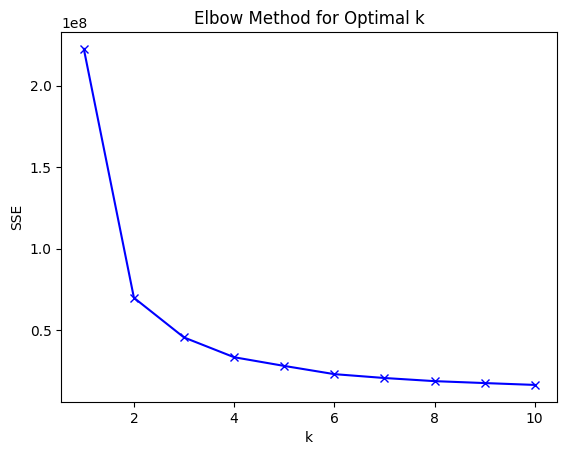

In [144]:
from sklearn.cluster import KMeans

# Set a range of k values to try
K = range(1, 11)

# Initialize an empty list to store SSE values for each k
sse = []

# Iterate over each k value and fit the KMeans model
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(node_embeddings)
    
    # Calculate the sum of squared errors and append to the list
    sse.append(kmeans.inertia_)

# Plot the SSE values against the number of clusters
plt.plot(K, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal k')
plt.show()

In [146]:
# Initialize the KMeans model with the optimal k value
k = 3
kmeans = KMeans(n_clusters=k)

# Fit the model to the data and predict the clusters for each data point
kmeans.fit(node_embeddings)
labels = kmeans.predict(node_embeddings)

In [153]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(node_embeddings)
X_tsne=pd.DataFrame(X_tsne)
X_tsne['cluster'] = labels
X_tsne['id'] = node_embeddings.index

/home/comex/Desktop/python-envs/main-bio/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/comex/Desktop/python-envs/main-bio/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [158]:
import plotly.express as px

fig = px.scatter(X_tsne, x=0, y=1, color='cluster', hover_data=['id'])
fig.show()